In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from gridworld.simulation import simulate_episode
from gridworld.agent import Agent, LoggerAgent
from gridworld.world import World, LoggerTrainingWorld
from gridworld.exploration import ExplorationMethod, EpsilonGreedy

from models.ann import DeepQNet
from models.utils import ReplayMemory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
print('Torch: ', torch.__version__)

load_model_name = None#'policy_2023-07-19_13-36.pth'

NUM_EPOCHS: int = 40
EPISODE_DURATION: int = 128
NUM_EPISODES_PER_EPOCH: int = 128
BATCH_SIZE: int = 64

DISCOUNT_FACTOR = 0.97
LEARNING_RATE = 1e-3
#RANDOM_EXPLORATION_DECAY = 0.95
MAX_EXPLORE_PROBABILITY = 1.0
MIN_EXPLORE_PROBABILITY = 0.1
WEIGHT_DECAY = 1e-4

agent: Agent = LoggerAgent()
world: World = LoggerTrainingWorld()
policy = DeepQNet(agent)

# Load models
if not load_model_name is None:
    policy.load_state_dict(torch.load(load_model_name))
policy = policy.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#torch.compile(policy) # Not supported in python 3.11

loss_history = []
exploration_method: ExplorationMethod = EpsilonGreedy(agent, device, epsilon = 1.0)
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    memories = ReplayMemory(agent, device)
    running_loss = 0.0
    for episode in range(NUM_EPISODES_PER_EPOCH):
        world = LoggerTrainingWorld()
        observations, actions, inventories, rewards, duration = simulate_episode(agent, world, policy, exploration_method, device, EPISODE_DURATION)
        memories.add_experience(observations, actions, inventories, rewards, discount_factor=DISCOUNT_FACTOR)

    episode_batches = memories.get_all_batches(BATCH_SIZE)
    for batch_data in episode_batches:
        optimizer.zero_grad()
        predicted_rewards = policy(batch_data.observations, batch_data.actions)
        loss = loss_fn(predicted_rewards, batch_data.rewards)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Record the running loss
    num_batches = len(memories.observations) // BATCH_SIZE
    loss_history.append(running_loss / num_batches)
    
    # Decay the exploration rate
    #exploration_method.epsilon = max(exploration_method.epsilon * RANDOM_EXPLORATION_DECAY, MIN_EXPLORE_PROBABILITY)
    exploration_method.epsilon = MIN_EXPLORE_PROBABILITY + (MAX_EXPLORE_PROBABILITY - MIN_EXPLORE_PROBABILITY) * np.exp(-epoch / NUM_EPOCHS)

Device:  cuda
Torch:  2.0.1+cu117


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
filename = f"output/policy_{timestamp}.pth"
torch.save(policy.state_dict(), filename)

Final loss: 7.605842008477166


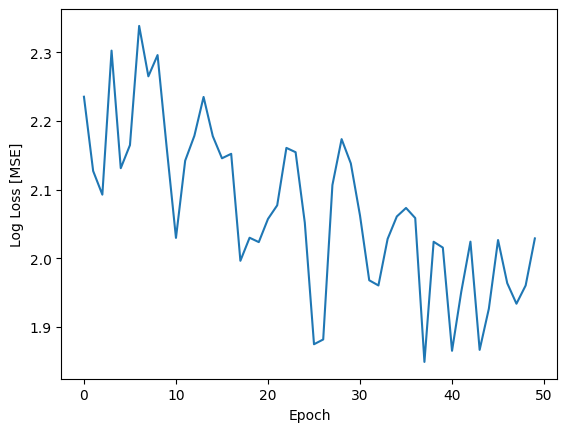

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(torch.log(torch.tensor(loss_history)))
plt.xlabel('Epoch')
plt.ylabel('Log Loss [MSE]')
print('Final loss:', loss_history[-1])